# NY Stock Exhange Stock Price Predictions RNN-LSTM


### Dataset consists of following files:

 prices.csv: raw, as-is daily prices. Most of data spans from 2010 to the end 2016, for companies new on stock market date range is shorter. There have been approx. 140 stock splits in that time, this set doesn't account for that.

 securities.csv: general description of each company with division on sectors


In [1]:
#importing important libraries
import numpy as np 
import pandas as pd 
import os 
import matplotlib.pyplot as plt 

import warnings
warnings.filterwarnings('ignore')

In [2]:
#load dataset1
df = pd.read_csv("prices.csv", header=0)
df.head()

,date,symbol,open,close,low,high,volume
0,2016-01-05 00:00:00,WLTW,123.430000,125.839996,122.309998,126.250000,2163600.0
1,2016-01-06 00:00:00,WLTW,125.239998,119.980003,119.940002,125.540001,2386400.0
2,2016-01-07 00:00:00,WLTW,116.379997,114.949997,114.930000,119.739998,2489500.0
3,2016-01-08 00:00:00,WLTW,115.480003,116.620003,113.500000,117.440002,2006300.0
4,2016-01-11 00:00:00,WLTW,117.010002,114.970001,114.089996,117.330002,1408600.0


In [3]:
#size of the dataset in 851264 rows and 7 columns
print(df.shape)

(851264, 7)


In [4]:
# takes 20 different and unique from symbol
df.symbol.unique()[0:20]

array(['WLTW', 'A', 'AAL', 'AAP', 'AAPL', 'ABC', 'ABT', 'ACN', 'ADBE',
       'ADI', 'ADM', 'ADP', 'ADS', 'ADSK', 'AEE', 'AEP', 'AES', 'AET',
       'AFL', 'AGN'], dtype=object)

In [5]:
# finind the length of column named symbol
print(len(df.symbol.values))

851264


In [6]:
#gives the details of each columns of the dataset like mean, max etc
df.describe()

,open,close,low,high,volume
count,851264.000000,851264.000000,851264.000000,851264.000000,8.512640e+05
mean,70.836986,70.857109,70.118414,71.543476,5.415113e+06
std,83.695876,83.689686,82.877294,84.465504,1.249468e+07
min,0.850000,0.860000,0.830000,0.880000,0.000000e+00
25%,33.840000,33.849998,33.480000,34.189999,1.221500e+06
50%,52.770000,52.799999,52.230000,53.310001,2.476250e+06
75%,79.879997,79.889999,79.110001,80.610001,5.222500e+06
max,1584.439941,1578.130005,1549.939941,1600.930054,8.596434e+08


In [7]:
#checking whether their is any null value in the dataset
# .sum() will give the total no. of null value column vise 
df.isnull().sum()

date      0
symbol    0
open      0
close     0
low       0
high      0
volume    0
dtype: int64

In [8]:
# taking all the unique or one time value in the date column 
df.date.unique()

array(['2016-01-05 00:00:00', '2016-01-06 00:00:00',
       '2016-01-07 00:00:00', ..., '2016-12-28', '2016-12-29',
       '2016-12-30'], dtype=object)

In [9]:
#load dataset 2
comp_info = pd.read_csv('securities.csv')
comp_info.head()

,Ticker symbol,Security,SEC filings,GICS Sector,GICS Sub Industry,Address of Headquarters,Date first added,CIK
0,MMM,3M Company,reports,Industrials,Industrial Conglomerates,"St. Paul, Minnesota",NaN,66740
1,ABT,Abbott Laboratories,reports,Health Care,Health Care Equipment,"North Chicago, Illinois",31-03-1964,1800
2,ABBV,AbbVie,reports,Health Care,Pharmaceuticals,"North Chicago, Illinois",31-12-2012,1551152
3,ACN,Accenture plc,reports,Information Technology,IT Consulting & Other Services,"Dublin, Ireland",06-07-2011,1467373
4,ATVI,Activision Blizzard,reports,Information Technology,Home Entertainment Software,"Santa Monica, California",31-08-2015,718877


In [10]:
# taking total no. of unique values in column Ticket symbol
comp_info["Ticker symbol"].nunique()

505

In [11]:
# for locating specific data here.... in security column of string that starts with "Face"
comp_info.loc[comp_info.Security.str.startswith('Face') , :]

,Ticker symbol,Security,SEC filings,GICS Sector,GICS Sub Industry,Address of Headquarters,Date first added,CIK
181,FB,Facebook,reports,Information Technology,Internet Software & Services,"Menlo Park, California",23-12-2013,1326801


In [12]:
# here we locate Ticker symbol of company with security like Yahoo, Xerox, Adobe etc 
comp_plot = comp_info.loc[(comp_info["Security"] == 'Yahoo Inc.') | (comp_info["Security"] == 'Xerox Corp.') | (comp_info["Security"] == 'Adobe Systems Inc')
              | (comp_info["Security"] == 'Microsoft Corp.') | (comp_info["Security"] == 'Adobe Systems Inc') 
              | (comp_info["Security"] == 'Facebook') | (comp_info["Security"] == 'Goldman Sachs Group') , ["Ticker symbol"] ]["Ticker symbol"] 
print(comp_plot)

6      ADBE
181      FB
212      GS
306    MSFT
496     XRX
500    YHOO
Name: Ticker symbol, dtype: object


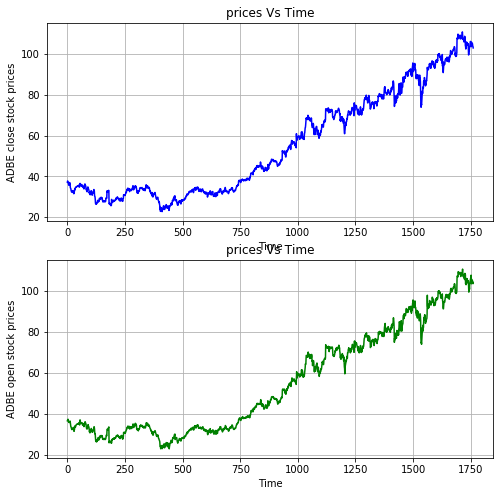

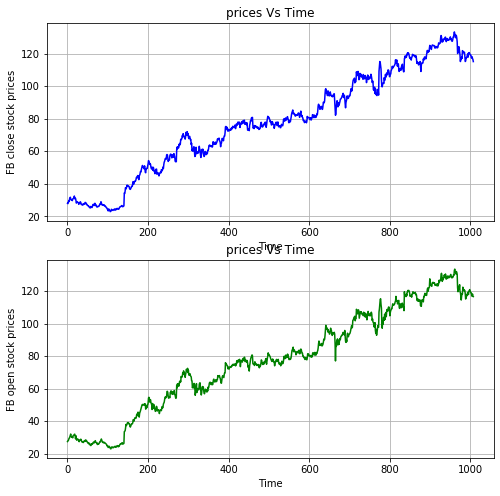

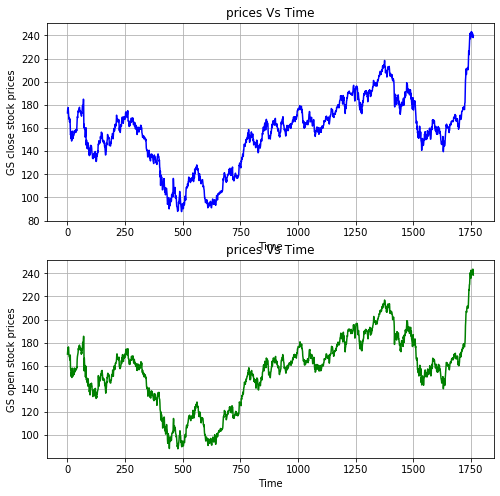

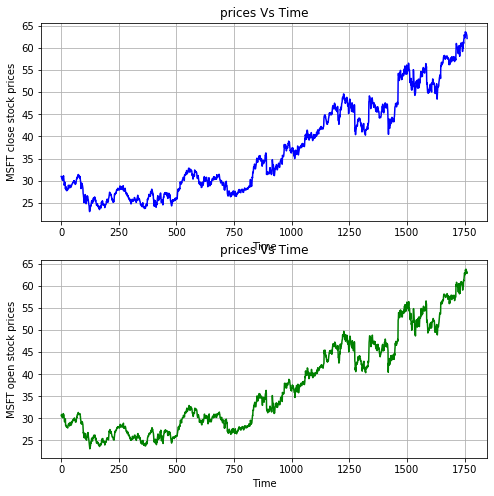

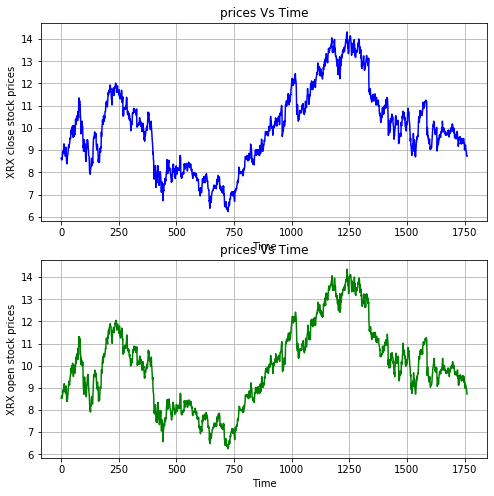

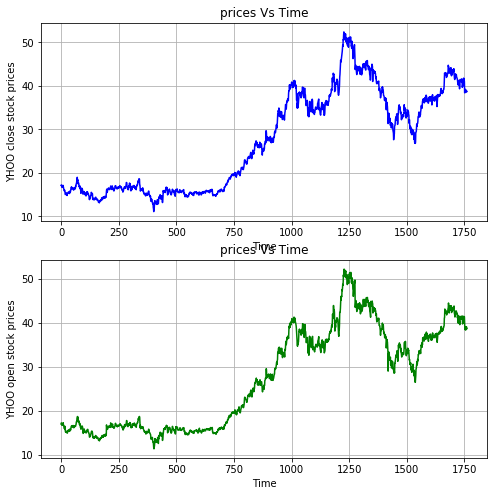

In [13]:
def plotter(code):
    
    global closing_stock ,opening_stock    
    f, axs = plt.subplots(2,2,figsize=(8,8))    
    plt.subplot(212)
    
    company = df[df['symbol']==code]   
    company = company.open.values.astype('float32')    
    company = company.reshape(-1, 1)     
    opening_stock = company
    
    
    plt.grid(True)
    plt.xlabel('Time') 
    plt.ylabel(code + " open stock prices")
    plt.title('prices Vs Time')
    plt.plot(company , 'g')     
    plt.subplot(211)
    
    company_close = df[df['symbol']==code]    
    company_close = company_close.close.values.astype('float32')    
    company_close = company_close.reshape(-1, 1)
    closing_stock = company_close
    
    
    plt.xlabel('Time') 
    plt.ylabel(code + " close stock prices")
    plt.title('prices Vs Time') 
    plt.grid(True)
    plt.plot(company_close , 'b')
    plt.show() 

# calling the graphs through the function    
for i in comp_plot:
    plotter(i)

**Lets take a single stock as a sample to forecast further stock prices.**

In [14]:
#taking the values of closing_stock in a single list
closing_stock[:,0]

array([17.1 , 17.23, 17.17, ..., 38.73, 38.64, 38.67], dtype=float32)

In [15]:
# taking the values of closing_stock in a single list called stocks
stocks = closing_stock[: , 0]
print(stocks)
#reshaping the stocks in 1D array form
stocks = stocks.reshape(len(stocks) , 1)

[17.1  17.23 17.17 ... 38.73 38.64 38.67]


In [16]:
# Feature scaling the vector for better model performance
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1)) #scaling features between 0 and 1
stocks = scaler.fit_transform(stocks) # it will start learning algo and then provide scaled and dimension reduced output

In [17]:
train = int(len(stocks) * 0.80)  # creating sizes of train and taking 80% percentage of the part
test = len(stocks) - train  #creating sizes of test as total minus train

In [18]:
#sizes of train and test
print(train , test)

1409 353


In [19]:
# divinding the values of stocks data to train from 0 to 1409 i.e 80% data
train = stocks[0:train]
print(train)

[[0.14559111]
 [0.14874032]
 [0.14728683]
 ...
 [0.63372093]
 [0.6145833 ]
 [0.6196705 ]]


In [20]:
#divinding the values of stocks data to test from train ending to stock data ending i.e rest 20% data
test = stocks[len(train) : ]

In [21]:
#reshaping train data in 1D array form
train = train.reshape(len(train) , 1)
#reshaping test data in 1D array form
test = test.reshape(len(test) , 1)

In [22]:
#new train and test array shape
print(train.shape , test.shape)

(1409, 1) (353, 1)


In [23]:
#creating function to create trainX,testX and target(trainY, testY)
def process_data(data , n_features):
    dataX, dataY = [], [] 
    for i in range(len(data)-n_features-1):
        
        a = data[i:(i+n_features), 0]
        
        dataX.append(a) 
        
        dataY.append(data[i + n_features, 0])
        
    return np.array(dataX), np.array(dataY)

# so the stucture of trainX and trainY is somehow like this
# trainX=[[i1 , i2,...., i n_features ]] and trainY=[i + n_features]  
# trainY will show the future value of trainX values

In [24]:
n_features = 2

trainX, trainY = process_data(train, n_features)

testX, testY = process_data(test, n_features)

In [25]:
# printing the structure of train X,Y and test X,Y
print(trainX.shape , trainY.shape , testX.shape , testY.shape)

(1406, 2) (1406,) (350, 2) (350,)


In [26]:
# reshaping trainX and testX to use in deeplearning model
trainX = trainX.reshape(trainX.shape[0] , 1 ,trainX.shape[1])
testX = testX.reshape(testX.shape[0] , 1 ,testX.shape[1])

In [27]:
import math 
from keras.models import Sequential
from keras.layers import Dense , BatchNormalization , Dropout , Activation 
from keras.layers import LSTM , GRU 
from sklearn.preprocessing import MinMaxScaler 
from sklearn.metrics import mean_squared_error 
from keras.optimizers import Adam , SGD , RMSprop 

In [28]:
from keras.callbacks import ReduceLROnPlateau , ModelCheckpoint

In [29]:
filepath = "stock_weights1.hdf5"

lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.1, epsilon=0.0001, patience=1, verbose=1)

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='max')

In [30]:
# creating model for training data using sequential to give series wise output between layers
model = Sequential()

model.add(GRU(256 , input_shape = (1 , n_features) , return_sequences=True))

model.add(Dropout(0.4))

model.add(LSTM(256))

model.add(Dropout(0.4))

model.add(Dense(64 ,  activation = 'relu'))
model.add(Dense(1))

print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 1, 256)            199680    
_________________________________________________________________
dropout (Dropout)            (None, 1, 256)            0         
_________________________________________________________________
lstm (LSTM)                  (None, 256)               525312    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense (Dense)                (None, 64)                16448     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 741,505
Trainable params: 741,505
Non-trainable params: 0
__________________________________________________

In [31]:
# selecting the loss measurement metrics and optimizer for our model , to find out mean square error
model.compile(loss='mean_squared_error', optimizer=Adam(lr = 0.0005) , metrics = ['mean_squared_error'])

In [32]:
# fitting the data i.e training the trainX, to relate to trainY
history = model.fit(trainX, trainY, epochs=100 , batch_size = 128 , 
          callbacks = [checkpoint , lr_reduce] , validation_data = (testX,testY))    


Epoch 1/100
11/11 [==============================] - 3s 100ms/step - loss: 0.1683 - mean_squared_error: 0.1683 - val_loss: 0.1680 - val_mean_squared_error: 0.1680

Epoch 00001: val_loss improved from -inf to 0.16796, saving model to stock_weights1.hdf5
Epoch 2/100
11/11 [==============================] - 0s 13ms/step - loss: 0.0588 - mean_squared_error: 0.0588 - val_loss: 0.0016 - val_mean_squared_error: 0.0016

Epoch 00002: val_loss did not improve from 0.16796
Epoch 3/100
11/11 [==============================] - 0s 12ms/step - loss: 0.0224 - mean_squared_error: 0.0224 - val_loss: 0.0020 - val_mean_squared_error: 0.0020

Epoch 00003: val_loss did not improve from 0.16796

Epoch 00003: ReduceLROnPlateau reducing learning rate to 5.0000002374872565e-05.
Epoch 4/100
11/11 [==============================] - 0s 12ms/step - loss: 0.0099 - mean_squared_error: 0.0099 - val_loss: 0.0032 - val_mean_squared_error: 0.0032

Epoch 00004: val_loss did not improve from 0.16796

Epoch 00004: ReduceLRO

11/11 [==============================] - 0s 14ms/step - loss: 0.0094 - mean_squared_error: 0.0094 - val_loss: 0.0033 - val_mean_squared_error: 0.0033

Epoch 00029: val_loss did not improve from 0.16796

Epoch 00029: ReduceLROnPlateau reducing learning rate to 5.0000007681717695e-31.
Epoch 30/100
11/11 [==============================] - 0s 14ms/step - loss: 0.0093 - mean_squared_error: 0.0093 - val_loss: 0.0033 - val_mean_squared_error: 0.0033

Epoch 00030: val_loss did not improve from 0.16796

Epoch 00030: ReduceLROnPlateau reducing learning rate to 5.000000956250865e-32.
Epoch 31/100
11/11 [==============================] - 0s 14ms/step - loss: 0.0095 - mean_squared_error: 0.0095 - val_loss: 0.0033 - val_mean_squared_error: 0.0033

Epoch 00031: val_loss did not improve from 0.16796

Epoch 00031: ReduceLROnPlateau reducing learning rate to 5.0000010738003005e-33.
Epoch 32/100
11/11 [==============================] - 0s 15ms/step - loss: 0.0094 - mean_squared_error: 0.0094 - val_loss: 

11/11 [==============================] - 0s 13ms/step - loss: 0.0093 - mean_squared_error: 0.0093 - val_loss: 0.0033 - val_mean_squared_error: 0.0033

Epoch 00061: val_loss did not improve from 0.16796
Epoch 62/100
11/11 [==============================] - 0s 13ms/step - loss: 0.0093 - mean_squared_error: 0.0093 - val_loss: 0.0033 - val_mean_squared_error: 0.0033

Epoch 00062: val_loss did not improve from 0.16796
Epoch 63/100
11/11 [==============================] - 0s 13ms/step - loss: 0.0093 - mean_squared_error: 0.0093 - val_loss: 0.0033 - val_mean_squared_error: 0.0033

Epoch 00063: val_loss did not improve from 0.16796
Epoch 64/100
11/11 [==============================] - 0s 13ms/step - loss: 0.0098 - mean_squared_error: 0.0098 - val_loss: 0.0033 - val_mean_squared_error: 0.0033

Epoch 00064: val_loss did not improve from 0.16796
Epoch 65/100
11/11 [==============================] - 0s 14ms/step - loss: 0.0095 - mean_squared_error: 0.0095 - val_loss: 0.0033 - val_mean_squared_erro

11/11 [==============================] - 0s 13ms/step - loss: 0.0099 - mean_squared_error: 0.0099 - val_loss: 0.0033 - val_mean_squared_error: 0.0033

Epoch 00099: val_loss did not improve from 0.16796
Epoch 100/100
11/11 [==============================] - 0s 13ms/step - loss: 0.0095 - mean_squared_error: 0.0095 - val_loss: 0.0033 - val_mean_squared_error: 0.0033

Epoch 00100: val_loss did not improve from 0.16796


In [33]:
#predicting the value for testX
pred = model.predict(testX)

pred = scaler.inverse_transform(pred)

pred[:10]
# taking pred from 1 to 10

array([[34.563328],
       [33.599304],
       [33.642044],
       [34.238922],
       [34.287975],
       [34.083725],
       [33.755527],
       [33.17163 ],
       [32.363758],
       [31.360617]], dtype=float32)

In [34]:
# reshaping testY in single array
testY = testY.reshape(testY.shape[0] , 1)

testY = scaler.inverse_transform(testY)

testY[:10]

array([[34.49    ],
       [35.93    ],
       [36.24    ],
       [36.1     ],
       [35.69    ],
       [35.19    ],
       [34.1     ],
       [32.93    ],
       [31.31    ],
       [31.739998]], dtype=float32)

Red - Predicted Stock Prices  ,  Blue - Actual Stock Prices


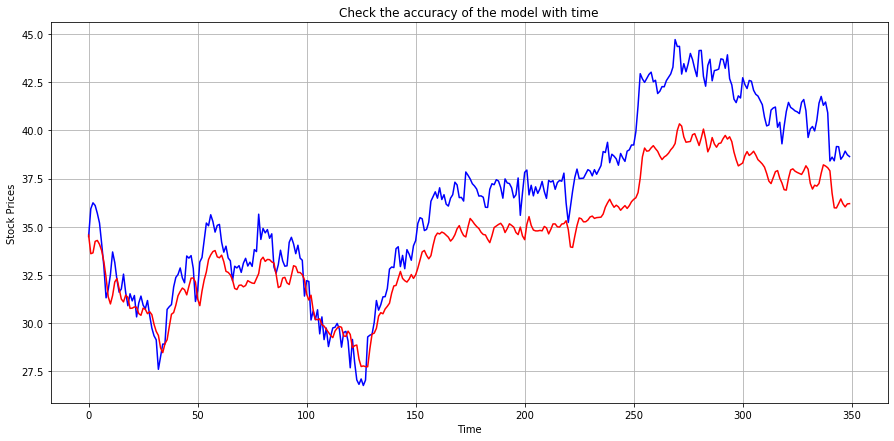

In [35]:
# ploting the graph of stock prices with time
print("Red - Predicted Stock Prices  ,  Blue - Actual Stock Prices")
plt.rcParams["figure.figsize"] = (15,7)

plt.plot(testY , 'b')

plt.plot(pred , 'r')

plt.xlabel('Time')

plt.ylabel('Stock Prices')

plt.title('Check the accuracy of the model with time')

plt.grid(True)

plt.show()